# Analysis to show hwo downsampling a BAM file affects the ability of a varaint caller (Mutect2) to detect variants in a truth set of variants

## Aim

* This analysis will will produce three outputs. First it will produce a csv containing each of the variants in the truth set along with a count which gives information on in how many replicates at that downsampling rate the variant was detected. The notebook also produces a similar CSV with the mean depth at which each variant was detected at that downsampling rate. The notebook will also produce a figure showing how the number of variants detected changes with the mean depth of the bam.

## Running

* Once you have run the snakemake part of the pipeline, open this notebook an change the sample_name and truth_set variables in cell 2. Also change the path to the list of expected variants. The notebook will assume that other relevant files are in the same position that the snakemake pipeline puts them at the end of the run.

* Please note the truth set will need to be a csv file where the first four columns are ('CHROM', 'POS', 'REF', 'ALT'). It should be simple to change the code to work with other file types here.

## Help

* Please contact Joseph Halstead joseph.halstead@wales.nsh.uk for more information.

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
sample_name = '180920_NB551319_0007_AH5GNLAFXY_18M05126-OS'
truth_set = '../misc/oncospanResults.txt'

expected_variants_df = pd.read_csv(truth_set, sep='\t', header=None, index_col=None)

In [3]:
expected_variants_df = expected_variants_df[[0,1,2,3]]
expected_variants_df.columns = ['CHROM', 'POS', 'REF', 'ALT']

In [4]:
def get_variant_key(df):
    """
    Create a key for each variant for joining tables etc.
    Key consists of CHROM-POS-REF-ALT
    """
    return df['CHROM'] + '-' + str(df['POS']) + '-' + df['REF'] + '-' + df['ALT']

In [5]:
expected_variants_df['variant_key'] = expected_variants_df.apply(get_variant_key, axis=1)

In [6]:
expected_variants_df.head()

,CHROM,POS,REF,ALT,variant_key
0,1,27056285,G,A,1-27056285-G-A
1,1,27100181,C,T,1-27100181-C-T
2,1,115256530,G,T,1-115256530-G-T
3,1,156846233,G,A,1-156846233-G-A
4,1,156846307,GC,G,1-156846307-GC-G


## Process CSVs with Variants in

* Here we open the CSVs produced by the snakemake variant calling pipeline.

In [7]:
variant_csvs = glob.glob('../output/csvs/{sample}*.csv'.format(sample=sample_name))

master_variant_df = pd.DataFrame()

for csv in variant_csvs:
    
    new_df = pd.read_csv(csv, sep='\t')
    
    new_df['file_name'] = csv
    
    master_variant_df = master_variant_df.append(new_df)

In [8]:
master_variant_df['variant_key'] = master_variant_df.apply(get_variant_key, axis=1)

In [9]:
def get_variant_sample(df):
    """
    Extract the sample name from the file.
    This function works on samples in the following format:
    e.g. 180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0.1_1.csv
    """
    return df['file_name'].split('/')[-1]

In [10]:
master_variant_df['variant_sample'] = master_variant_df.apply(get_variant_sample, axis=1)

In [11]:
def get_variant_down_sample_rate(df):
    """
    Extract the downsample rate from the file.
    """
    return df['file_name'].split('/')[-1].split('_')[-2]

In [12]:
master_variant_df['variant_downsample_rate'] = master_variant_df.apply(get_variant_down_sample_rate, axis=1)

In [13]:
def get_variant_down_sample_replicate(df):
    
     return df['file_name'].split('/')[-1].split('_')[-1].split('.')[0]

In [14]:
master_variant_df['variant_downsample_rate_replicate'] = master_variant_df.apply(get_variant_down_sample_replicate, axis=1)

In [15]:
# Create a merged dataframe with a row for each CSV and each variant i.e. product the two.

merged_list = []

for run in variant_csvs:
    
    for index, row in expected_variants_df.iterrows():
        
        merged_list.append([run, row[0], row[1], row[2], row[3], row[4]])

In [16]:
merged_df = pd.DataFrame(merged_list, columns=['file_name','CHROM', 'POS','REF', 'ALT', 'variant_key'])

In [17]:
merged_df.head()

,file_name,CHROM,POS,REF,ALT,variant_key
0,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,27056285,G,A,1-27056285-G-A
1,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,27100181,C,T,1-27100181-C-T
2,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,115256530,G,T,1-115256530-G-T
3,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,156846233,G,A,1-156846233-G-A
4,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,156846307,GC,G,1-156846307-GC-G


In [18]:
#Merge the merged dataframe with the master_variant_df

final_merged = pd.merge(merged_df, master_variant_df, on=['file_name','variant_key' ], how='left', )

In [19]:
final_merged.head()

,file_name,CHROM_x,POS_x,REF_x,ALT_x,variant_key,CHROM_y,POS_y,REF_y,ALT_y,DP,TLOD,18M05126-OS.AD,18M05126-OS.AF,18M05126-OS.GT,18M05126-OS.F1R2,18M05126-OS.F2R1,variant_sample,variant_downsample_rate,variant_downsample_rate_replicate
0,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,27056285,G,A,1-27056285-G-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,27100181,C,T,1-27100181-C-T,1,27100181.0,C,T,10.0,10.82,"5,4",0.454,C/T,"3,2","2,2",180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0....,0.005,1
2,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,115256530,G,T,1-115256530-G-T,1,115256530.0,G,T,5.0,5.62,"3,2",0.400,G/T,"2,0","1,2",180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0....,0.005,1
3,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,156846233,G,A,1-156846233-G-A,1,156846233.0,G,A,9.0,13.21,"5,4",0.444,G/A,"1,3","4,1",180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0....,0.005,1
4,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,156846307,GC,G,1-156846307-GC-G,1,156846307.0,GC,G,9.0,7.06,"5,3",0.389,GC/G,"3,2","2,1",180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0....,0.005,1


In [20]:
def get_sample_name(df):
    """
    Get the sample name from the file.
    """
    
    file_name = df['file_name'].split('/')[-1]
        
    split_file_name = file_name.split('_')
    
    return '_'.join(split_file_name[0:-2])

In [21]:
final_merged['sample_name'] = final_merged.apply(get_sample_name, axis=1)

In [22]:
final_merged.head()

,file_name,CHROM_x,POS_x,REF_x,ALT_x,variant_key,CHROM_y,POS_y,REF_y,ALT_y,...,TLOD,18M05126-OS.AD,18M05126-OS.AF,18M05126-OS.GT,18M05126-OS.F1R2,18M05126-OS.F2R1,variant_sample,variant_downsample_rate,variant_downsample_rate_replicate,sample_name
0,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,27056285,G,A,1-27056285-G-A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180920_NB551319_0007_AH5GNLAFXY_18M05126-OS
1,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,27100181,C,T,1-27100181-C-T,1,27100181.0,C,T,...,10.82,"5,4",0.454,C/T,"3,2","2,2",180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0....,0.005,1,180920_NB551319_0007_AH5GNLAFXY_18M05126-OS
2,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,115256530,G,T,1-115256530-G-T,1,115256530.0,G,T,...,5.62,"3,2",0.400,G/T,"2,0","1,2",180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0....,0.005,1,180920_NB551319_0007_AH5GNLAFXY_18M05126-OS
3,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,156846233,G,A,1-156846233-G-A,1,156846233.0,G,A,...,13.21,"5,4",0.444,G/A,"1,3","4,1",180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0....,0.005,1,180920_NB551319_0007_AH5GNLAFXY_18M05126-OS
4,../output/csvs/180920_NB551319_0007_AH5GNLAFXY...,1,156846307,GC,G,1-156846307-GC-G,1,156846307.0,GC,G,...,7.06,"5,3",0.389,GC/G,"3,2","2,1",180920_NB551319_0007_AH5GNLAFXY_18M05126-OS_0....,0.005,1,180920_NB551319_0007_AH5GNLAFXY_18M05126-OS


In [23]:
#Create two pivot tables with a multi index and variants along the top.

pivoted_df_count = final_merged.pivot_table(index=['sample_name', 'variant_downsample_rate'], columns='variant_key', dropna=False, values='DP', aggfunc='count')

pivoted_df_mean = final_merged.pivot_table(index=['sample_name', 'variant_downsample_rate'], columns='variant_key', dropna=False, values='DP', aggfunc='mean')

In [24]:
# Make variants be rows

final_variant_df_count = pivoted_df_count.transpose()
final_pivoted_df_mean = pivoted_df_mean.transpose()

In [25]:
# Depth calculations

In [26]:
# Get the depth information
depth_csvs = glob.glob('../output/depth/{sample}*.txt'.format(sample=sample_name))

master_depth_df = pd.DataFrame()

for file in depth_csvs:
    
    new_df = pd.read_csv(file, sep='\t')
    
    new_df['file_name'] = file
        
    master_depth_df = master_depth_df.append(new_df)

In [27]:
master_depth_df.head()

,# chrom,chromStart,chromEnd,F3,readCount,meanCoverage,sampleName,file_name
0,1,836813,836885,rs_id:rs28705752,4,2.277780,18M05126-OS,../output/depth/180920_NB551319_0007_AH5GNLAFX...
1,1,1338988,1339057,rs_id:rs17363048,4,3.739130,18M05126-OS,../output/depth/180920_NB551319_0007_AH5GNLAFX...
2,1,1891966,1892044,rs_id:rs2803292,5,3.692310,18M05126-OS,../output/depth/180920_NB551319_0007_AH5GNLAFX...
3,1,2402506,2402581,rs_id:rs2494627,1,0.653333,18M05126-OS,../output/depth/180920_NB551319_0007_AH5GNLAFX...
4,1,2943184,2943263,rs_id:rs7412983,8,3.886080,18M05126-OS,../output/depth/180920_NB551319_0007_AH5GNLAFX...


In [28]:
master_depth_df['sample'] = master_depth_df.apply(get_sample_name,axis=1)

In [29]:
master_depth_df['variant_downsample_rate'] = master_depth_df.apply(get_variant_down_sample_rate, axis=1)

In [30]:
depth_df_grouped = master_depth_df.groupby(['sample','variant_downsample_rate'] ).mean()

In [31]:
depth_variant_count_df = pd.DataFrame(final_variant_df_count.count())

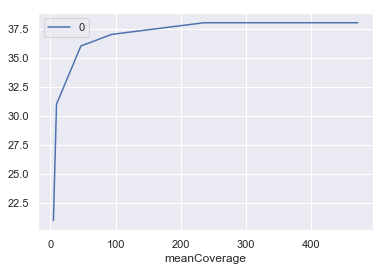

In [32]:
depth_variant_count_df.merge(depth_df_grouped, on='variant_downsample_rate').plot(x='meanCoverage', y=0,)

In [36]:
final_pivoted_df_mean

sample_name                   180920_NB551319_0007_AH5GNLAFXY_18M05126-OS  \
variant_downsample_rate                                             0.005   
variant_key                                                                 
1-115256530-G-T                                                       5.0   
1-156846233-G-A                                                       9.0   
1-156846307-GC-G                                                      7.0   
1-156848995-C-T                                                       8.0   
1-27056285-G-A                                                        NaN   
1-27100181-C-T                                                       10.0   
10-43595968-A-G                                                       NaN   
10-43604493-C-T                                                       5.0   
10-43613843-G-T                                                       6.0   
12-25398281-C-T                                                       NaN   
12-25398284-C-T                                                       NaN   
13-32911888-A-G                                                       8.0   
13-32912299-T-C                                                       NaN   
13-32912750-G-T                                                       NaN   
13-32913558-CA-C                                                      NaN   
13-32913836-CA-C                                                      6.0   
13-32936646-T-C                                                       NaN   
15-88576185-G-C                                                       6.0   
15-88680684-G-A                                                      10.5   
17-37879588-A-G                                                       8.5   
17-37879762-G-A                                                       NaN   
17-41234451-G-A                                                       NaN   
17-41251931-G-A                                                       NaN   
17-7577644-C-G                                                        NaN   
17-7579472-G-C                                                        5.0   
3-178936091-G-A                                                       NaN   
3-178947865-G-A                                                       NaN   
3-178952085-A-G                                                       8.0   
4-55152040-C-T                                                        NaN   
4-55599321-A-T                                                        NaN   
6-117678083-A-G                                                       3.0   
6-117686840-T-C                                                       NaN   
6-117718110-C-T                                                       9.0   
6-117730819-G-A                                                       NaN   
7-116339847-GT-G                                                     13.0   
7-116436022-G-A                                                       NaN   
7-140453136-A-T                                                       NaN   
7-55241707-G-A                                                        8.0   
7-55242464-AGGAATTAAGAGAAGC-A                                         NaN   
7-55249063-G-A                                                       14.0   
7-55249071-C-T                                                        NaN   
7-55259515-T-G                                                        NaN   
X-66765142-G-A                                                        NaN   
X-66765627-G-A                                                        4.0   
X-76938088-GTC-G                                                      7.0   

sample_name                                                      
variant_downsample_rate        0.01   0.05    0.1   0.25    0.5  
variant_key                                                      
1-115256530-G-T                 NaN   54.0  100.0  268.5  547.5  
1-156846233-G-A                12.0   6